####  Submitted By: Lior Kricheli, Eliran Malka and Itamar Yacoby

## Final Project in Deep Learning

### Lecturer - Dr. Jonathan Rubin

#### Holon Institute of Technology - 21.06.2021

#### This project uses the colorectal histology dataset by tensorflow

##### This project aims to train a deep learning model to help classify tumorous cells in a biopsy test

In [1]:
pip install patchify

Note: you may need to restart the kernel to use updated packages.


In [2]:
# TensorFlow and tf.keras
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import cv2
import tifffile as tiff

from sklearn.metrics import confusion_matrix
from seaborn import heatmap 
from sklearn.manifold import TSNE
from patchify import patchify

print(tf.__version__)

2.3.0


# IMPORTANT!
## Choose bellow the right cell to run (Colab or PC)

In [3]:
# #USE THIS CELL TO RUN ON COLAB

# !git clone https://github.com/ithamar000/DeepLearningFinalProject.git

# pathTrain = '/content/DeepLearningFinalProject/archive/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/train'
# pathTest = '/content/DeepLearningFinalProject/archive/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/validation'

In [4]:
# #USE THIS CELL TO RUN ON PC

# pathTrain = 'archive\\Kather_texture_2016_image_tiles_5000\\Kather_texture_2016_image_tiles_5000\\train'
# pathTest = 'archive\\Kather_texture_2016_image_tiles_5000\\Kather_texture_2016_image_tiles_5000\\validation'

# Part 1: Function Defenitions

#### plot_results(history)

plot the accuracy and loss.

##### history - contains the accuracy and loss of a trained model

In [5]:
def plot_results(history):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'],':r')
    plt.plot(history.history['val_loss'],'.-r')
    plt.title('Loss',fontsize=14)
    plt.xlabel('Epochs',fontsize=14)
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'],':b')
    plt.plot(history.history['val_accuracy'],'b')
    plt.ylim([0, 1])
    plt.title('Accuracy',fontsize=14)
    plt.xlabel('Epochs',fontsize=14)
    plt.grid()

#### plot_confusion_matrix(model, test_generator)
plot a confusion matrix

##### model - The trained model
##### test_generator - the generator used by the model

In [6]:
# Function to plot a confusion matrix

def plot_confusion_matrix(model, test_generator):
    true_labels = test_generator.classes
    predictions = model.predict(test_generator)
    y_true = true_labels
    y_pred = np.array([np.argmax(x) for x in predictions])
    cm = confusion_matrix(y_true, y_pred)
    CM = cm / cm.sum(axis=1)


    plt.figure(figsize=(10,8))
    heatmap(CM,cmap='Blues',annot=True, fmt='.2%')
    plt.xlabel('Predicted label', fontsize=20)
    plt.ylabel('True label', fontsize=20)
    plt.show()

#### visualize_labelled_data(model, test_generator)

Function to plot a visualization of labelled-data distribution in 2D (Using t-SNE) 

##### model - The trained model
##### test_generator - the generator used by the model

In [7]:
# Function to plot a visualization of labelled-data distribution in 2D (Using t-SNE) 

def visualize_labelled_data(model, test_generator):
    features_extractor = keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
    features = features_extractor.predict(test_generator)

    X_embedded = TSNE(n_components=2).fit_transform(features)
    y = test_generator.classes

    plt.figure(figsize=(10,8))
    plt.scatter(X_embedded[:,0],X_embedded[:,1],80,y, 
                cmap='tab20', alpha=0.7, edgecolors='k')
    plt.colorbar()
    plt.show()

#### get_data_gen(data_augmentation)

Returns data generator

if data_augmentation == True -> applying data augmentation to images

else the images remains in their original condition

##### data_augmentation - boolean to decide if data augmentation is wanted


In [8]:

def get_data_gen(data_augmentation):
    
    my_batch_size = 32  
    
    if(data_augmentation):
        dataGen = ImageDataGenerator(shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     rotation_range=30,
                                     width_shift_range=2,)
        
        train_generator = dataGen.flow_from_directory(pathTrain,
                                                      batch_size=my_batch_size, 
                                                      class_mode='categorical')

        dataGenTest = ImageDataGenerator()
        test_generator = dataGenTest.flow_from_directory(pathTest,                                              
                                                     batch_size=my_batch_size, 
                                                     class_mode='categorical', 
                                                     shuffle=False)
    else:
        dataGen = ImageDataGenerator()
        train_generator = dataGen.flow_from_directory(pathTrain,
                                                      batch_size=my_batch_size, 
                                                      class_mode='categorical')

        dataGenTest = ImageDataGenerator()
        test_generator = dataGenTest.flow_from_directory(pathTest,                                              
                                                     batch_size=my_batch_size, 
                                                     class_mode='categorical', 
                                                     shuffle=False)
    return train_generator,test_generator

#### get_big_model()

Returns a ConvNet Model containing mulitple Conv Layers, Dropout, and Max Pooling



In [9]:
def get_big_model():
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (150, 150, 3)))
    model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3)) 

    model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
    model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
    model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3)) 

    model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3))

    model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(8, activation = 'softmax'))
    
    return model


#### get_small_model()

Returns a small ConvNet model containing some Conv Layers and Max Pooling without Dropout



In [10]:
def get_small_model():
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (150, 150, 3)))
    model.add(MaxPooling2D(pool_size = 3)) 
    model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
    model.add(MaxPooling2D(pool_size = 3)) 
    model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 3))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(8, activation = 'softmax'))
    
    return model

# Part 2: Training Multiple Models

#### In this part we will train three different model with different complexity
#### In the table below you can see the results we achieved with each model

## Summary of results:

<table>
  <tr>
    <th>Model</th>
    <th>#parameters</th>
    <th>epochs</th>
    <th>train accuracy</th>
    <th>test accuracy</th>
  </tr>
    
  <!-- copy this block once for every model you tested -->  
  <tr> 
    <td>> Simple ConvNet </td>   <!-- Model -->
    <td>> 0 </td> <!-- Parameters -->
    <td>> 10 </td> <!-- epochs -->
    <td>> 0.0 </td> <!-- train -->
    <td>> 0.0 </td> <!--  test -->
  </tr>

  <tr> 
    <td>> Simple ConvNet Data Augmentation</td>   <!-- model -->
    <td>> 0 </td> <!-- parameters -->
    <td>> 20 </td> <!-- epochs -->
    <td>> 0.0</td> <!-- train -->
    <td>> 0.0 </td> <!-- test -->
  </tr>

  <tr> 
    <td>> Bigger ConvNet Data Augmentation + Adam optimizer</td>   <!-- model -->
    <td>> 0 </td> <!-- parameters -->
    <td>> 30 </td> <!-- epochs -->
    <td>> 0.0</td> <!-- train -->
    <td>> 0.0 </td> <!-- test -->
  </tr>
    
</table>




In [11]:
#initializing  two sets of data generator, one with augmentaion and one without.

train_generator_original ,test_generator_original = get_data_gen(False)
train_generator_aug, test_generator_aug = get_data_gen(True)


Found 4504 images belonging to 8 classes.
Found 496 images belonging to 8 classes.
Found 4504 images belonging to 8 classes.
Found 496 images belonging to 8 classes.


In [12]:
small_model = get_small_model()
small_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
global_max_pooling2d (Global (None, 64)                0

In [13]:
small_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 50

small_model_history = small_model.fit(train_generator_original,
                                      steps_per_epoch=train_generator_original.samples/train_generator_original.batch_size, 
                                      validation_data=test_generator_original,
                                      epochs=epochs, batch_size=20, verbose=1)

Epoch 1/50
141/140 [==============================] - 45s 322ms/step - loss: 5.3161 - accuracy: 0.4041 - val_loss: 1.0627 - val_accuracy: 0.6048
Epoch 2/50
141/140 [==============================] - 44s 315ms/step - loss: 1.0597 - accuracy: 0.6108 - val_loss: 0.7334 - val_accuracy: 0.7702
Epoch 3/50
141/140 [==============================] - 44s 311ms/step - loss: 0.7960 - accuracy: 0.7036 - val_loss: 0.7795 - val_accuracy: 0.7097
Epoch 4/50
141/140 [==============================] - 42s 301ms/step - loss: 0.6810 - accuracy: 0.7518 - val_loss: 0.5978 - val_accuracy: 0.8065
Epoch 5/50
141/140 [==============================] - 42s 301ms/step - loss: 0.6006 - accuracy: 0.7735 - val_loss: 0.5688 - val_accuracy: 0.8004
Epoch 6/50
141/140 [==============================] - 43s 302ms/step - loss: 0.5538 - accuracy: 0.7980 - val_loss: 0.8293 - val_accuracy: 0.7560
Epoch 7/50
141/140 [==============================] - 42s 301ms/step - loss: 0.5067 - accuracy: 0.8179 - val_loss: 0.6029 - val_ac

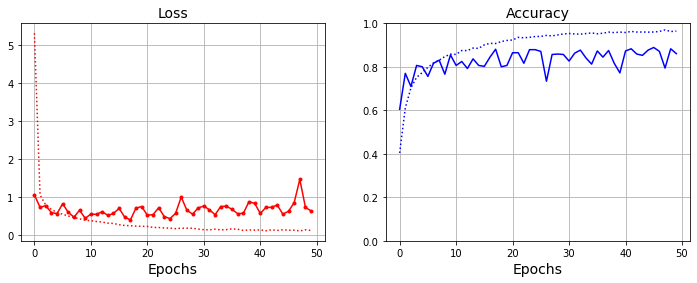

In [14]:
plot_results(small_model_history)

In [15]:
small_model.save('models//small_model_50.h5') 

In [16]:
small_model_aug = get_small_model()
small_model_aug.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 100

small_model_aug_history = small_model_aug.fit(train_generator_aug,
                                      steps_per_epoch=train_generator_aug.samples/train_generator_aug.batch_size, 
                                      validation_data=test_generator_aug,
                                      epochs=epochs, batch_size=20, verbose=1)

Epoch 1/100
141/140 [==============================] - 71s 501ms/step - loss: 3.5742 - accuracy: 0.3950 - val_loss: 1.0621 - val_accuracy: 0.5927
Epoch 2/100
141/140 [==============================] - 70s 498ms/step - loss: 1.0579 - accuracy: 0.5990 - val_loss: 0.6535 - val_accuracy: 0.7500
Epoch 3/100
141/140 [==============================] - 70s 497ms/step - loss: 0.8647 - accuracy: 0.6692 - val_loss: 0.7234 - val_accuracy: 0.7359
Epoch 4/100
141/140 [==============================] - 70s 497ms/step - loss: 0.7448 - accuracy: 0.7151 - val_loss: 0.5196 - val_accuracy: 0.8185
Epoch 5/100
141/140 [==============================] - 70s 498ms/step - loss: 0.6756 - accuracy: 0.7502 - val_loss: 0.6478 - val_accuracy: 0.7500
Epoch 6/100
141/140 [==============================] - 70s 498ms/step - loss: 0.6289 - accuracy: 0.7664 - val_loss: 0.6804 - val_accuracy: 0.7581
Epoch 7/100
141/140 [==============================] - 70s 497ms/step - loss: 0.6043 - accuracy: 0.7691 - val_loss: 0.4627 -

Epoch 57/100
141/140 [==============================] - 70s 498ms/step - loss: 0.3446 - accuracy: 0.8806 - val_loss: 0.4888 - val_accuracy: 0.8569
Epoch 58/100
141/140 [==============================] - 70s 497ms/step - loss: 0.3554 - accuracy: 0.8754 - val_loss: 0.4044 - val_accuracy: 0.8629
Epoch 59/100
141/140 [==============================] - 70s 497ms/step - loss: 0.3348 - accuracy: 0.8823 - val_loss: 0.5379 - val_accuracy: 0.8266
Epoch 60/100
141/140 [==============================] - 70s 496ms/step - loss: 0.3263 - accuracy: 0.8861 - val_loss: 0.5441 - val_accuracy: 0.8145
Epoch 61/100
141/140 [==============================] - 70s 496ms/step - loss: 0.3666 - accuracy: 0.8708 - val_loss: 0.3821 - val_accuracy: 0.8690
Epoch 62/100
141/140 [==============================] - 70s 497ms/step - loss: 0.3476 - accuracy: 0.8814 - val_loss: 0.5440 - val_accuracy: 0.8407
Epoch 63/100
141/140 [==============================] - 70s 498ms/step - loss: 0.3551 - accuracy: 0.8743 - val_loss: 0

In [18]:
small_model_aug.save('models//small_model_aug_100.h5') 

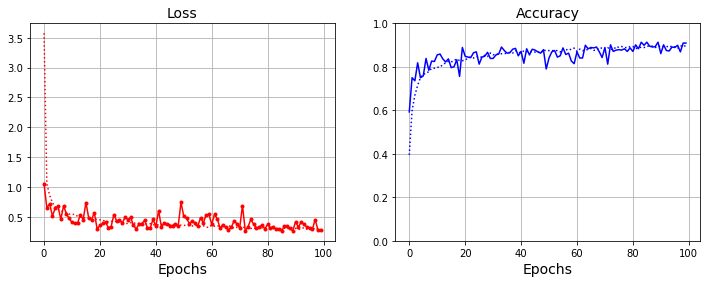

In [19]:
plot_results(small_model_aug_history)

In [20]:
big_model_aug = get_big_model()
big_model_aug.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 16)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 32)       

In [ ]:
big_model_aug.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 200

big_model_aug_history = big_model_aug.fit(train_generator_aug, steps_per_epoch=train_generator_aug.samples/train_generator_aug.batch_size, 
          validation_data=test_generator_aug,
          epochs=epochs, batch_size=20, verbose=1)

# Part 2.1: Visualizing the results of our best model

AttributeError: 'list' object has no attribute 'history'

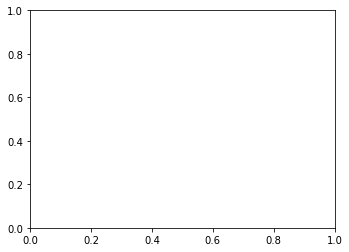

In [199]:
plot_results(big_model_aug_history)

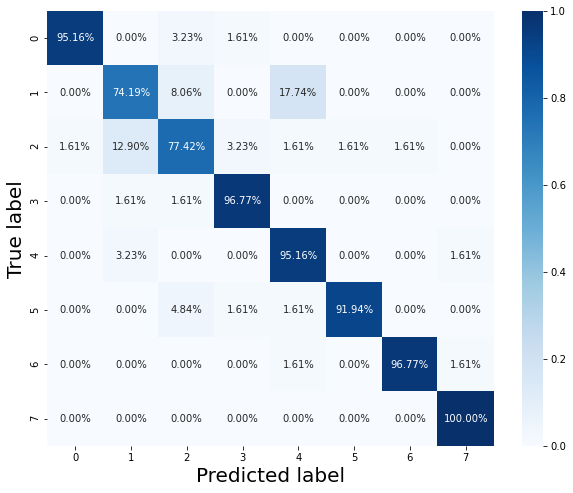

In [23]:
plot_confusion_matrix(big_aug_model,test_generator_aug)

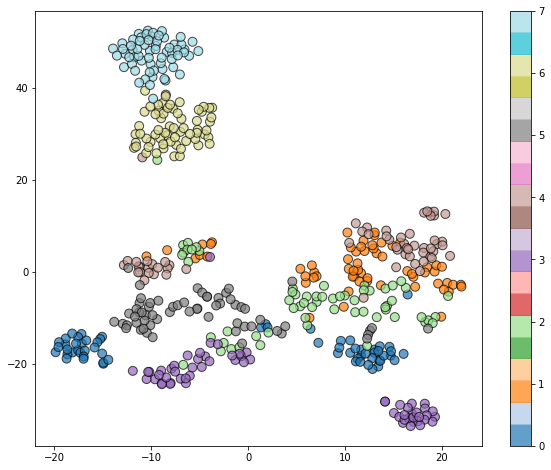

In [24]:
visualize_labelled_data(big_model_aug, test_generator_aug)

# Part 3: Image Segmentation

#### In this part we will use the trained model to classify small patches of a large image to help detect tumors
#### We will also show the probability of each cell to be tumorous

In [ ]:
for x in range(1,11):
    path = 'archive\Kather_texture_2016_larger_images_10\Kather_texture_2016_larger_images_10\CRC-Prim-HE-0'+str(x)+'_APPLICATION.tif'
    image = tiff.imread(path)
    patches = patchify(image, (150, 150, 3), step=75)
    patches_shape = patches.shape
    colored_patches = np.zeros((patches_shape[0],patches_shape[1]))
    tumor_prob = np.zeros((patches_shape[0],patches_shape[1]))
    
    for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                single_patch = patches[i,j,:,:,:]
                colored_patches[i,j] = np.argmax(small_model_aug.predict(single_patch))
                tumor_prob[i,j] = small_model_aug.predict(single_patch)[0,0]

    fig = plt.figure(figsize=(15,15))
    plt.subplot(11,3,3*x-2)
    plt.title("Classification Result")
    plt.imshow(colored_patches,cmap='Set1')
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_ticks([0,1,2,3,4,5,6,7])
    cbar.set_ticklabels(['Tumor', 'Storma','Complex','Lympho','Debris','Mucosa','Adipose','Empty'])

    plt.subplot(11,3,3*x-1)
    plt.title("Original Image")
    plt.imshow(image)

    plt.subplot(11,3,3*x)
    plt.title("Tumor Epithelium Probability")
    plt.imshow(tumor_prob,cmap='hot')
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    fig.tight_layout()

# Part 4: Used Resources:



In [ ]:
#TODO: Add various used resoruces